In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

import collections

import sys
sys.path.append('../Tianwen')

import ccsds

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

from construct import *

AOSFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / ccsds.GreedyBytes
)

In [2]:
frames = np.fromfile('hmap_frames_2022-11-16T15:00:44.u8', 'uint8').reshape(-1, 5*223-2)
frames.shape

(534, 1113)

## AOS frames

Frames are AOS frames using spacecraft ID `0xd6` (assigned to [LunaH-Map in SANA registry](https://sanaregistry.org/r/spacecraftid/records/14601)). Virtual channels 2 and 63 (OID) are in use.

In [3]:
aos = [ccsds.AOSPrimaryHeader.parse(f) for f in frames]
scid = [a.spacecraft_id for a in aos]
vcid = np.array([a.virtual_channel_id for a in aos])
vcfc = np.array([a.virtual_channel_frame_count for a in aos])
aos[:5]

[Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=2, virtual_channel_frame_count=1705, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=2, virtual_channel_frame_count=1706, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=63, virtual_channel_frame_count=585, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=2, virtual_channel_frame_count=1707, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=2, virtual_channel_frame_count=1708, replay_flag=False, vc_frame_count_usage_flag=

In [4]:
collections.Counter(scid)

Counter({214: 534})

In [5]:
collections.Counter(vcid)

Counter({2: 398, 63: 136})

## VC 2

Virtual channel 2 carries data using the M_PDU protocol and Space Packets. Only APIDs 66 and 2047 are in use. APID 66 is used to send packets of 1501 bytes (including the Space Packet Primary Header) containing telemetry. An idle packet in APID 2047 of 709 bytes is sent after each APID 66 packet in order to fill the remaining part of an AOS frame. The contents of APID 2047 idle packets are filled with `0xdc` bytes.

The packet sequence count is always 0.

In [6]:
frame_loss_vc2 = np.sum(np.diff(vcfc[vcid == 2]) - 1)
frame_loss_vc2

0

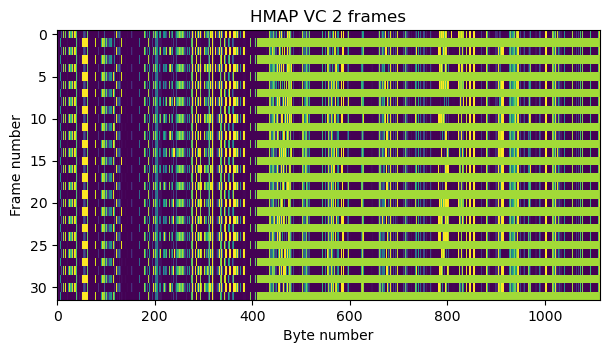

In [7]:
plt.imshow(frames[vcid == 2][:32], aspect='auto', interpolation='none')
plt.title('HMAP VC 2 frames')
plt.ylabel('Frame number')
plt.xlabel('Byte number');

In [8]:
frames_vc2 = [AOSFrame.parse(f) for f in frames[vcid == 2]]
packets = list(ccsds.extract_space_packets(frames_vc2, 214, 2))

In [9]:
packet_headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in packets]

In [10]:
packet_headers[:4]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=66, sequence_flags=3, packet_sequence_count_or_name=0, data_length=1494),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=702),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=66, sequence_flags=3, packet_sequence_count_or_name=0, data_length=1494),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=702)]

In [11]:
apids = collections.Counter([p.APID for p in packet_headers])
apids

Counter({66: 199, 2047: 199})

In [12]:
by_apid = {apid : [p for h,p in zip(packet_headers, packets)
                   if h.APID == apid] for apid in apids}

In [13]:
idle_packets = np.array([np.frombuffer(a, 'uint8') for a in by_apid[2047]])
np.all(idle_packets[:, ccsds.SpacePacketPrimaryHeader.sizeof():] == 0xdc)

True

In [14]:
np.all(idle_packets == idle_packets[0])

True

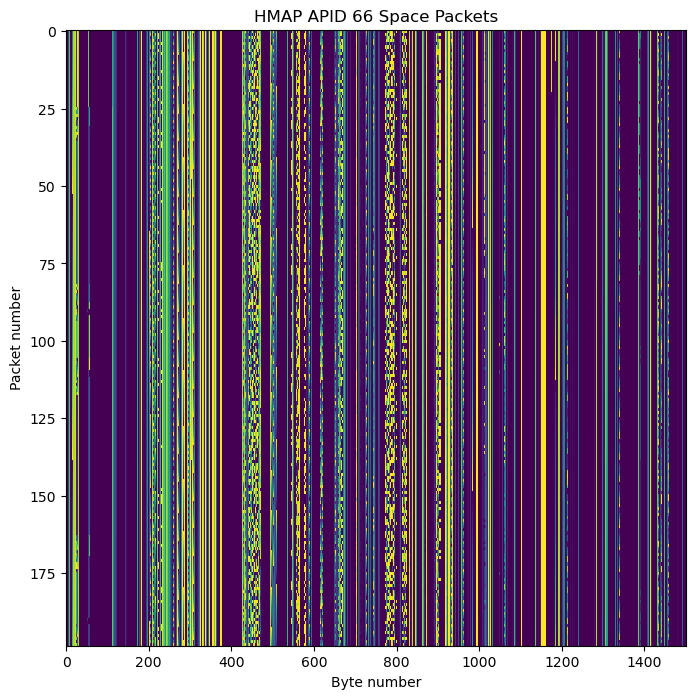

In [15]:
apid66 = np.array([np.frombuffer(a, 'uint8') for a in by_apid[66]])
plt.figure(figsize=(8, 8))
plt.imshow(apid66, aspect='auto', interpolation='none')
plt.title('HMAP APID 66 Space Packets')
plt.ylabel('Packet number')
plt.xlabel('Byte number');

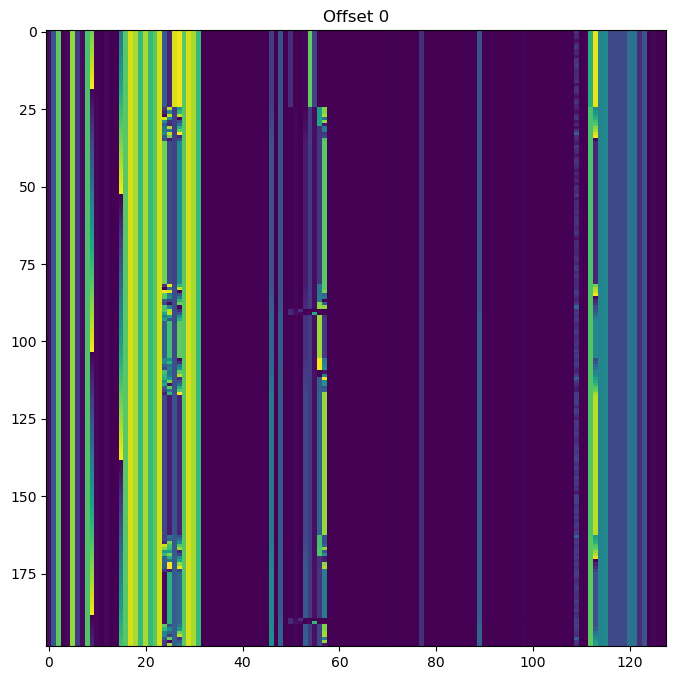

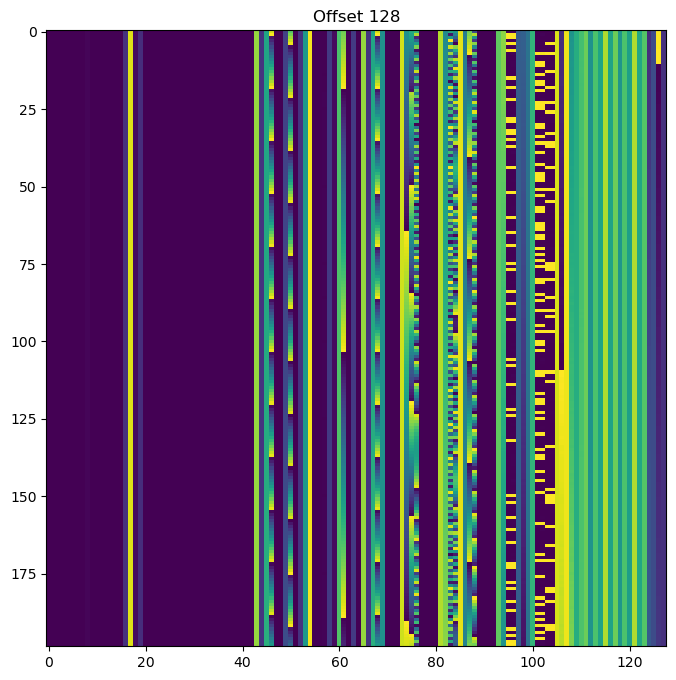

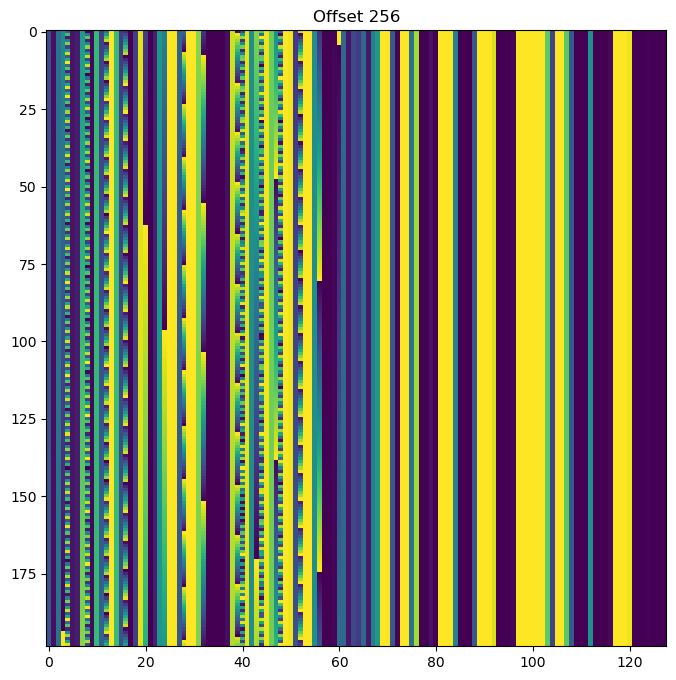

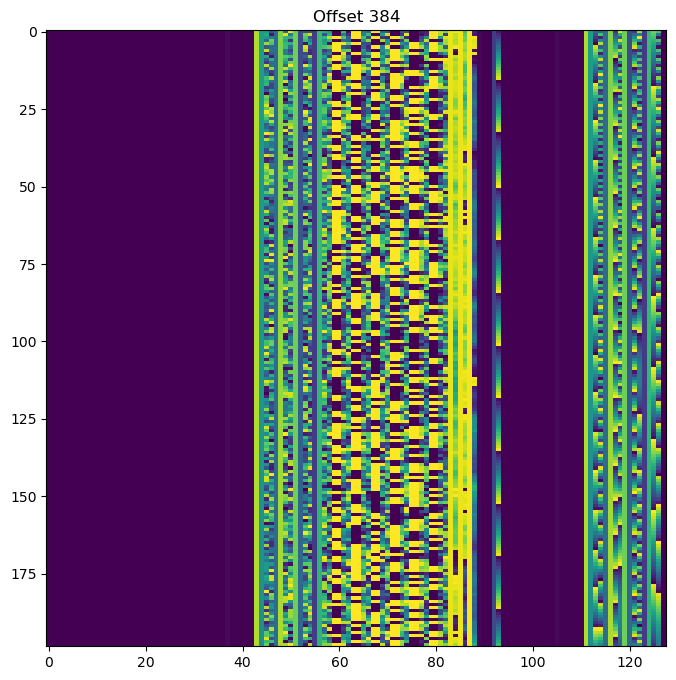

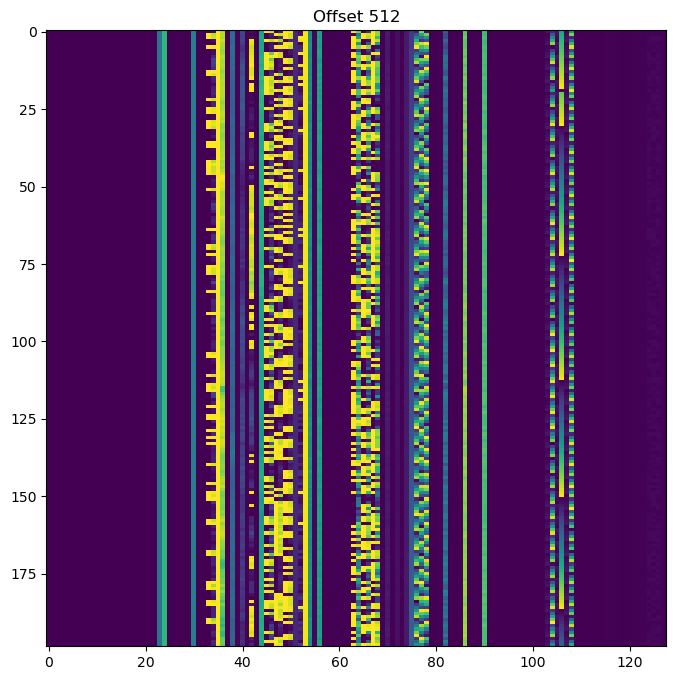

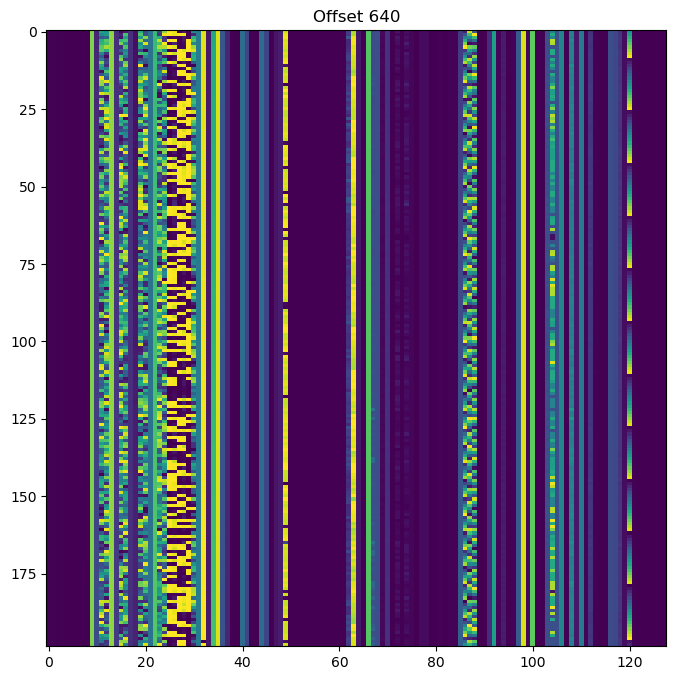

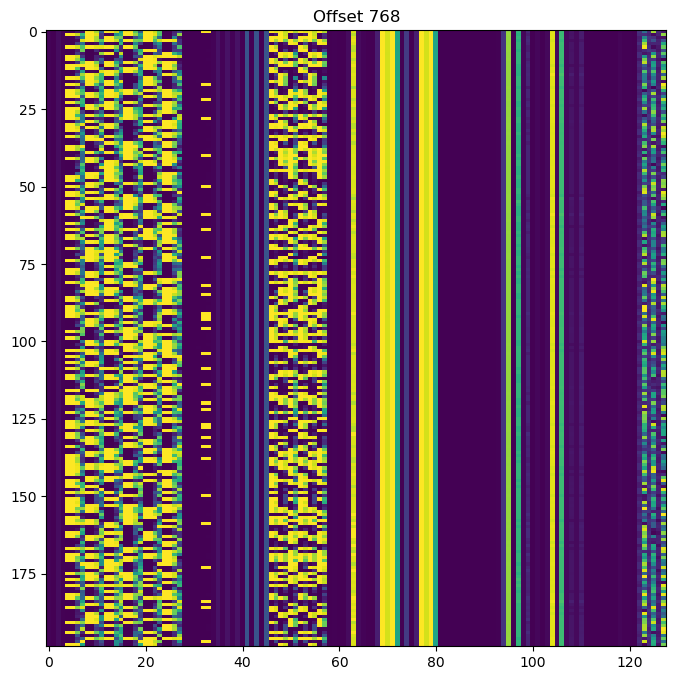

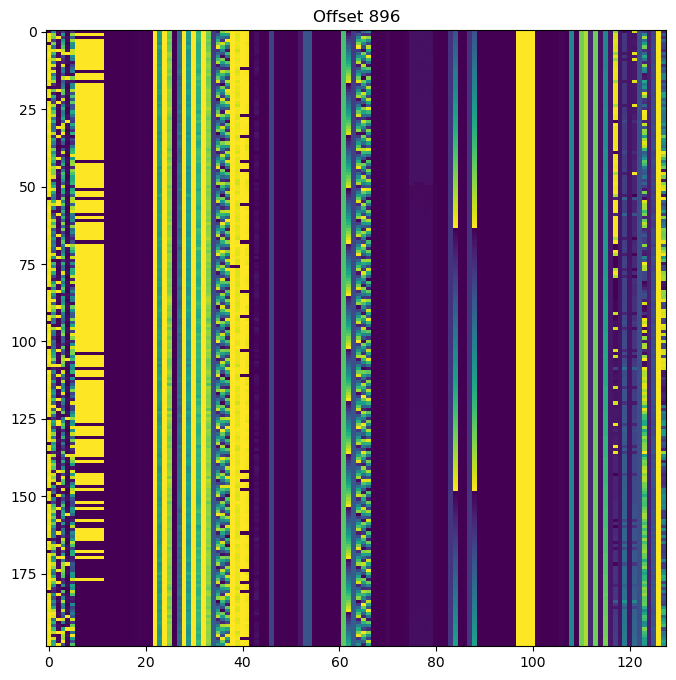

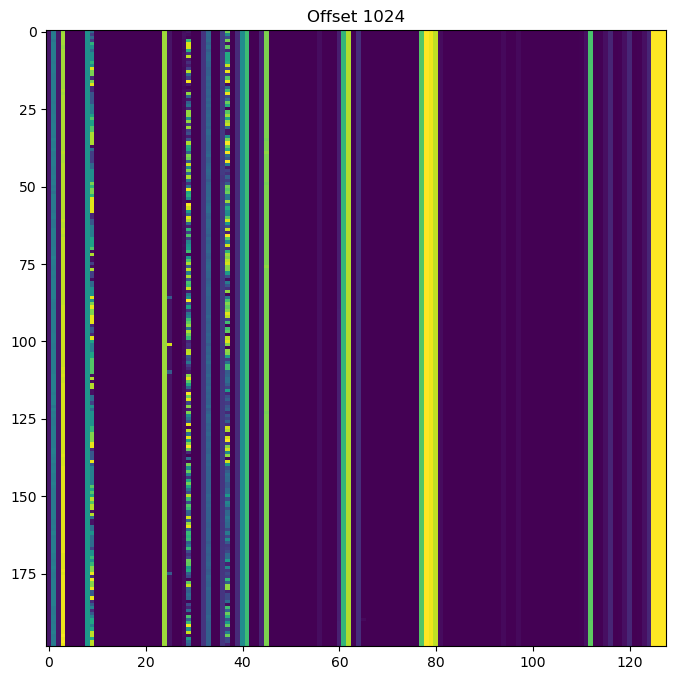

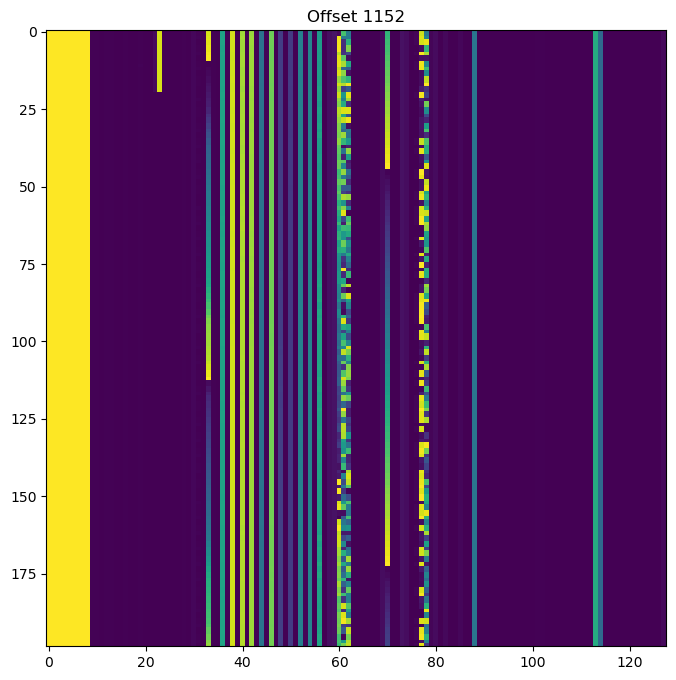

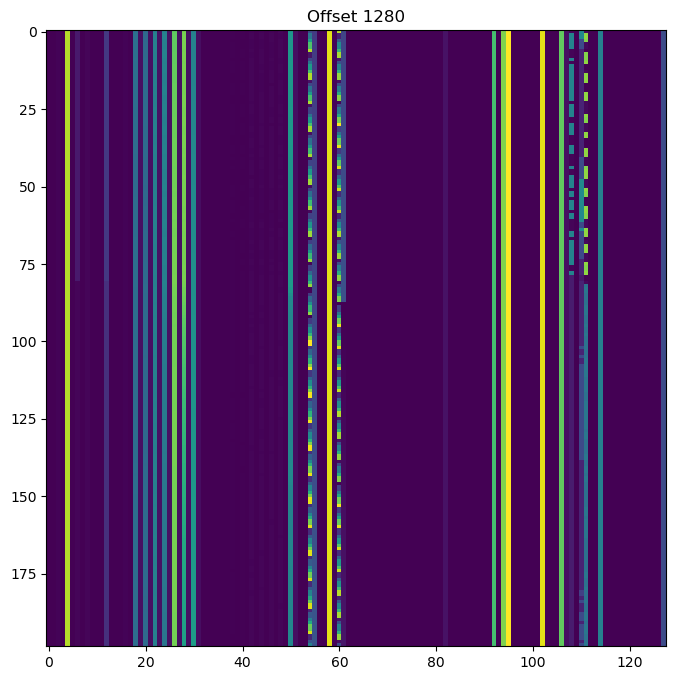

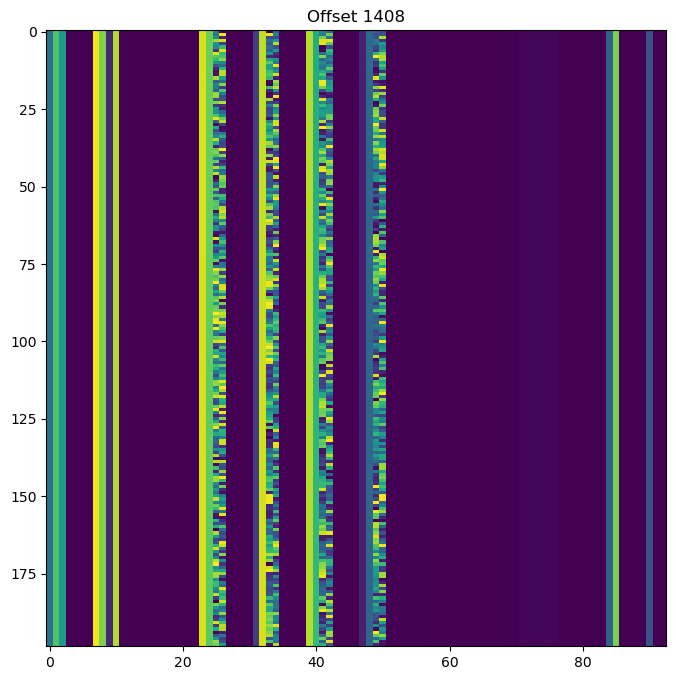

In [16]:
apid66 = np.array([np.frombuffer(a, 'uint8') for a in by_apid[66]])

for j in range(12):
    plt.figure(figsize=(8, 8))
    plt.imshow(apid66[:, j*128:(j+1)*128], aspect='auto', interpolation='none')
    plt.title(f'Offset {j*128}')

These bytes contain a counter that seems to increase by 3 always.

In [17]:
np.diff(apid66[:, 8:10].view('uint16').byteswap().ravel())

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
      dtype=uint16)

These bytes seem to contain quaternions as `int32` using the scale factor `1e9`. The quaternions change very slowly. It is not clear what they represent.

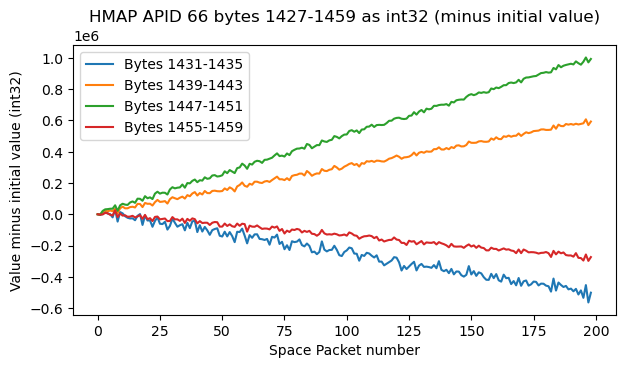

In [31]:
z = apid66[:, 1408+19:][:, :4*8].view('int32').byteswap()[:, 1::2]
plt.plot(z - z[0])
plt.title('HMAP APID 66 bytes 1427-1459 as int32 (minus initial value)')
plt.legend([f'Bytes {a}-{a+4}' for a in range(1427+4, 1459, 8)])
plt.ylabel('Value minus initial value (int32)')
plt.xlabel('Space Packet number');

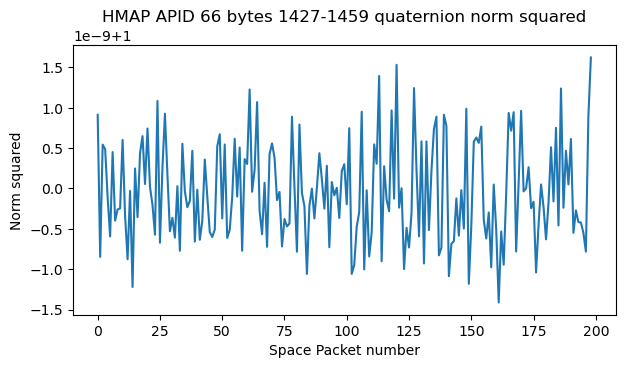

In [19]:
zscale = 1e9
z_float = z.astype('float') / zscale
plt.plot(np.sum(z_float**2, axis=1))
plt.title('HMAP APID 66 bytes 1427-1459 quaternion norm squared')
plt.xlabel('Space Packet number')
plt.ylabel('Norm squared');

In [29]:
q = Rotation.from_quat(z_float[:, [1, 2, 3, 0]]) # scalar last format
H = q*q[0].inv()
V = H.as_quat()[:,:-1]
V /= np.sqrt(np.sum(V**2, axis = -1))[..., np.newaxis]

/tmp/ipykernel_488568/351576588.py:4: RuntimeWarning: invalid value encountered in divide
  V /= np.sqrt(np.sum(V**2, axis = -1))[..., np.newaxis]


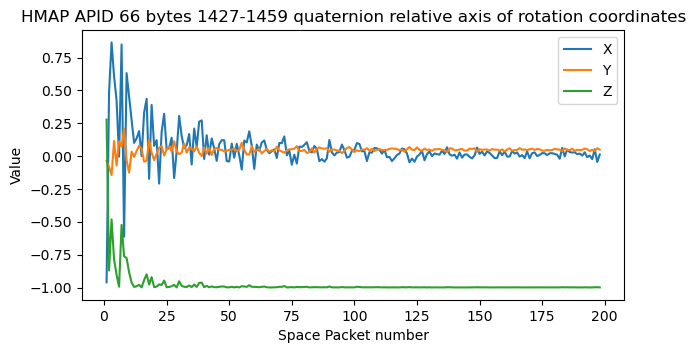

In [21]:
plt.plot(V)
plt.legend(['X', 'Y', 'Z'])
plt.title('HMAP APID 66 bytes 1427-1459 quaternion relative axis of rotation coordinates')
plt.xlabel('Space Packet number')
plt.ylabel('Value');

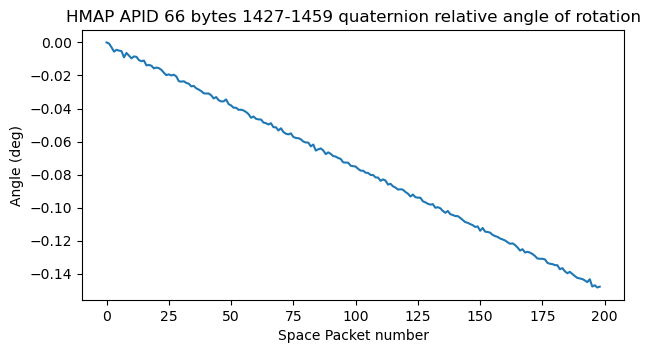

In [32]:
theta = 2 * np.arctan2(np.sqrt(np.sum(H.as_quat()[:,:-1]**2, axis = 1)), H.as_quat()[:,-1])
theta = (theta + np.pi) % (2 * np.pi) - np.pi
plt.plot(np.rad2deg(theta))
plt.title('HMAP APID 66 bytes 1427-1459 quaternion relative angle of rotation')
plt.xlabel('Space Packet number')
plt.ylabel('Angle (deg)');

## VC 63

Idle frames in VC 63 contain `0x07fe` after the AOS primary header. This is most likely an M_PDU header indicating that the packet zone contains only idle data. The packet zone is filled with `0xdc`.

In [23]:
[a for a in aos if a.virtual_channel_id == 63][:5]

[Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=63, virtual_channel_frame_count=585, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=63, virtual_channel_frame_count=586, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=63, virtual_channel_frame_count=587, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=63, virtual_channel_frame_count=588, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=214, virtual_channel_id=63, virtual_channel_frame_count=589, replay_flag=False, vc_frame_count_usage_flag=

In [24]:
np.all(frames[vcid == 63, 6:8] == [0x7, 0xfe])

True

In [25]:
ccsds.M_PDU_Header.parse(frames[vcid == 63][0, 6:8])

Container(rsv_spare=0, first_header_pointer=2046)

In [26]:
np.all(frames[vcid == 63, 8:] == 0xdc)

True

In [27]:
frame_loss_vc63 = np.diff(vcfc[vcid == 63]) - 1
frame_loss_vc63

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

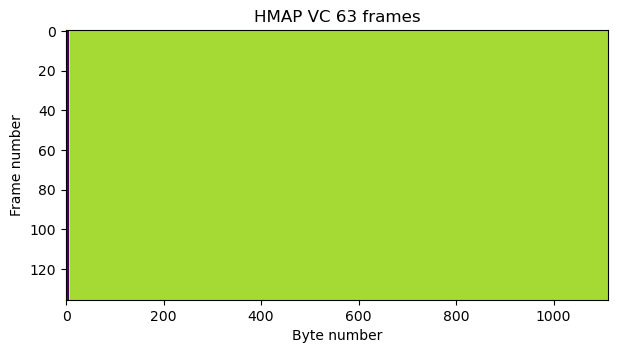

In [28]:
plt.figure()
plt.imshow(frames[vcid == 63], aspect='auto', interpolation='none')
plt.title('HMAP VC 63 frames')
plt.ylabel('Frame number')
plt.xlabel('Byte number');